https://github.com/keras-team/keras/blob/master/examples/mnist_transfer_cnn.py

** Transfer learning toy example**

- Train a simple convnet on the MNIST dataset the first 5 digits [0...4].
- Freeze convolutional layers and fine-tune dense/output layers for the classification for the rest digits [5...9].

Get to 99.8% test accuracy after 5 epochs for the first five digits classifier and 99.2% for the last five digits after transfer + fine-tuning.

In [1]:
from __future__ import print_function 

import datetime
import keras 
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten 
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from scipy.misc import imresize

Using TensorFlow backend.


In [22]:
now = datetime.datetime.now

batch_size = 128

num_classes = 5

epochs = 5

In [23]:
# input image dimensions 
img_rows, img_cols = 28, 28

# number of convolutional filters to use 
filters = 32

# convolutional kernel size 
kernel_size = 3

# size of pooling area for max pooling
pool_size = 2


In [24]:
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    # tf backend has K.image_data_format() == 'channels_last'
    input_shape = (img_rows, img_cols, 1)

In [25]:
def train_model(model, train, test, num_classes):
    
    # change input data size so they match tensorflow requirements
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    # normalization like 
    x_train /= 255
    x_test /= 255
    
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    # one hot encode class vectors 
    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)
    
    # compile for training
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adadelta', metrics = ['accuracy'])
    
    t = now()
    model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (x_test, y_test))
    
    print('Training time: %s' % (now() - t))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

In [26]:
# load the data

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(x_train[0].shape)

(60000, 28, 28)
(28, 28)


In [27]:
# create two datasets one with digits below 5 and the other above

x_train_lt5 = x_train[y_train < 5]
y_train_lt5 = y_train[y_train < 5]
x_test_lt5 = x_test[y_test < 5]
y_test_lt5 = y_test[y_test < 5]

x_train_gte5 = x_train[y_train >= 5]
y_train_gte5 = y_train[y_train >= 5] - 5
x_test_gte5 = x_test[y_test >= 5]
y_test_gte5 = y_test[y_test >= 5] - 5

print(x_train_lt5.shape)
print(x_train_lt5[0].shape)

(30596, 28, 28)
(28, 28)


In [161]:
# define two groups of layers: feature(convolutions) and classification(dense)

feature_layers = [Conv2D(filters, kernel_size, padding = 'valid', input_shape = input_shape),
                 Activation('relu'),
                 Conv2D(filters, kernel_size),
                 Activation('relu'),
                 MaxPooling2D(pool_size = pool_size),
                 Dropout(0.25),
                 Flatten()]


classification_layers = [Dense(128),
                         Activation('relu'),
                         Dropout(0.5), 
                         Dense(num_classes), 
                         Activation('softmax')]

In [162]:
# create the complete model

model_fc = Sequential(feature_layers + classification_layers)

In [163]:
model_fc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_13 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
__________

In [30]:
# train model for 5-digit clasification [0...4]

train_model(model_fc, (x_train_lt5, y_train_lt5), (x_test_lt5, y_test_lt5), num_classes)

x_train shape: (30596, 28, 28, 1)
30596 train samples
5139 test samples
Train on 30596 samples, validate on 5139 samples
Epoch 1/5
30596/30596 [==============================] - 53s 2ms/step - loss: 0.1744 - acc: 0.9437 - val_loss: 0.0274 - val_acc: 0.9903
Epoch 2/5
30596/30596 [==============================] - 55s 2ms/step - loss: 0.0477 - acc: 0.9854 - val_loss: 0.0174 - val_acc: 0.9942
Epoch 3/5
30596/30596 [==============================] - 57s 2ms/step - loss: 0.0321 - acc: 0.9908 - val_loss: 0.0098 - val_acc: 0.9969
Epoch 4/5
30596/30596 [==============================] - 51s 2ms/step - loss: 0.0262 - acc: 0.9923 - val_loss: 0.0179 - val_acc: 0.9946
Epoch 5/5
30596/30596 [==============================] - 52s 2ms/step - loss: 0.0215 - acc: 0.9934 - val_loss: 0.0085 - val_acc: 0.9973
Training time: 0:04:28.141054
Test score: 0.008491175898898667
Test accuracy: 0.9972757345787118


In [31]:
# freeze feature layers and rebuild the model for a different classification task [5...9]

for l in feature_layers:
    l.trainable = False

In [32]:
# tranfer - train dense layers for new classification task [5...9]. training using new task data 

train_model(model_fc , (x_train_gte5, y_train_gte5), (x_test_gte5, y_test_gte5), num_classes)

x_train shape: (29404, 28, 28, 1)
29404 train samples
4861 test samples
Train on 29404 samples, validate on 4861 samples
Epoch 1/5
29404/29404 [==============================] - 21s 704us/step - loss: 0.2463 - acc: 0.9245 - val_loss: 0.0523 - val_acc: 0.9842
Epoch 2/5
29404/29404 [==============================] - 21s 718us/step - loss: 0.0801 - acc: 0.9764 - val_loss: 0.0385 - val_acc: 0.9872
Epoch 3/5
29404/29404 [==============================] - 19s 658us/step - loss: 0.0595 - acc: 0.9813 - val_loss: 0.0305 - val_acc: 0.9895
Epoch 4/5
29404/29404 [==============================] - 20s 665us/step - loss: 0.0504 - acc: 0.9838 - val_loss: 0.0318 - val_acc: 0.9893
Epoch 5/5
29404/29404 [==============================] - 19s 644us/step - loss: 0.0467 - acc: 0.9855 - val_loss: 0.0237 - val_acc: 0.9930
Training time: 0:01:39.823435
Test score: 0.023744944033462122
Test accuracy: 0.9930055544126722


## transfer learning with VGG and MNIST

- **retrain output dense layer only/ using VGG as feature extractor(bottleneck feature)** The output layer in a vgg16 is a softmax activation with 1000 categories. Remove this layer and use the remaining model to extract features. Retrain a separated classificstion layer only using the features extracted from VGG. **cannot use data augmentation in this case**

- **retrain all layers but with replaced Dense layer/ using VGG as feature extractor(bottleneck feature)** The output layer in a vgg16 is a softmax activation with 1000 categories. Remove this layer and replace it with a softmax layer of 10 categories. Retrain the modified VGG model using the features extracted from VGG without Dense layer.**can use data augmentation in this case**

- **freeze the weights of the first few layers** the first few layers capture universal features like curves and edges, which are also relevant to the new problem. VGG architectue is not changed in this case, but image size is **different** from which (224 x 224) VGG is trained on. Easier to retrain on the Dense layer Repalced VGG16. - fine tuning?

## VGG16 as feature extractor & feed the features to a simple linear model

### VGG16 has requirement on minimium input size, which cannot be met by MNIST input without modification 

In [2]:
# retrain output dense layer only

from keras.applications.vgg16 import VGG16
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

10469376/11490434 [==========================>...] - ETA: 0s

In [4]:
img_rows, img_cols = 28, 28

batch_size = 32

num_classes = 10

epochs = 30

In [5]:
# load VGG16 model weights

model = VGG16(weights = 'imagenet', include_top = False)
model.summary()

57360384/58889256 [============================>.] - ETA: 0s_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (Max

In [6]:
# check which backend is used and reshape the data to match Keras' expectation 

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

### repeat the gray scale channel to create three channels for all images before resizing them 

In [7]:
# VGG is trained on color images - repeat grayscale image over three color channels
# np.repeat - if ``axis = 0`` it will be the first dimension and if ``axis = -1`` it will be the last dimension.
# expand channels for both training and testing images 

train_color_channel = []
for i in range(x_train.shape[0]):
    train_color_channel.append(np.repeat(x_train[i], 3, axis = -1))
    
test_color_channel = []
for i in range(x_test.shape[0]):
    test_color_channel.append(np.repeat(x_test[i], 3, axis = -1))

In [8]:
# change unit8 data type

x_train = np.array(train_color_channel).astype('float32')
x_test = np.array(test_color_channel).astype('float32')

x_train.shape

(60000, 28, 28, 3)

### resize images to meet VGG16 minimum requirement on input size 

In [9]:
### resize does not work for images with only one color channel, but for 3 and 4 channels 

from skimage.transform import resize 

def resize (images):
    x = np.zeros((images.shape[0], 56, 56, 3))
    for i in range(images.shape[0]):
        x[i] = imresize(images[i], (56, 56, 3), interp = 'bilinear', mode = None)
    
    return x

In [10]:
# resize images from (28, 28) to (56, 56)
x_train = resize(x_train)
x_test = resize(x_test)


# normalization like 
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print('number of train samples: ', x_train.shape[0])
print('number of test samples: ', x_test.shape[0])
print('number of train sample labels: ', y_train.shape[0])


# one hot encode class vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 56, 56, 3)
number of train samples:  60000
number of test samples:  10000
number of train sample labels:  60000


In [41]:
np.save('x_train.npy', x_train)
np.save('x_test.npy', x_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [ ]:
# extract features from training and testing data using pretrained VGG16 without top 

now = datetime.datetime.now
t = now()

feature_train = model.predict(x_train)
feature_test = model.predict(x_test)

print('Feature extracting time: %s' % (now() - t))

print(feature_train.shape)
print(feature_test.shape)


In [11]:
# load features extracted using FloydHub

feature_train = np.load('feature_train.npy')
feature_test = np.load('feature_test.npy')

print(feature_train.shape)
print(feature_test.shape)

(60000, 1, 1, 512)
(10000, 1, 1, 512)


In [21]:
# load the data without reshaping

feature_train = np.load('feature_train.npy')
feature_test = np.load('feature_test.npy')

# create the simple linear model that will be fed with extracted features 

new_model = Sequential()

# input_shape is the image/feature shape 
new_model.add(Flatten(input_shape = (1, 1, 512)))

new_model.add(Dense(256, activation = 'relu', input_shape = (512, )))
new_model.add(Dropout(0.5))
new_model.add(Dense(10, activation = 'softmax'))

new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 133,898
Trainable params: 133,898
Non-trainable params: 0
_________________________________________________________________


In [22]:

# model compile 
new_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# model fitting 
# - x_train in the original model.fit has to be of (num_exampels, nrows, ncols, nchannels)
# - now only the Dense layer is trained, x_trian's size should match this requiremnt 

history = new_model.fit(feature_train, y_train, batch_size = batch_size, 
                        epochs = epochs, validation_data = (feature_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 7s 115us/step - loss: 0.3908 - acc: 0.8829 - val_loss: 0.1429 - val_acc: 0.9585
Epoch 2/30
60000/60000 [==============================] - 6s 98us/step - loss: 0.1700 - acc: 0.9471 - val_loss: 0.1123 - val_acc: 0.9674
Epoch 3/30
60000/60000 [==============================] - 6s 96us/step - loss: 0.1400 - acc: 0.9562 - val_loss: 0.1190 - val_acc: 0.9621
Epoch 4/30
60000/60000 [==============================] - 6s 108us/step - loss: 0.1241 - acc: 0.9606 - val_loss: 0.0869 - val_acc: 0.9726
Epoch 5/30
60000/60000 [==============================] - 5s 91us/step - loss: 0.1138 - acc: 0.9636 - val_loss: 0.0840 - val_acc: 0.9727
Epoch 6/30
60000/60000 [==============================] - 5s 92us/step - loss: 0.1063 - acc: 0.9659 - val_loss: 0.0770 - val_acc: 0.9766
Epoch 7/30
60000/60000 [==============================] - 5s 90us/step - loss: 0.1013 - acc: 0.9674 - val_loss: 0.0772 - val_a

In [23]:
new_model.evaluate(feature_test, y_test)

10000/10000 [==============================] - 0s 32us/step


[0.07039157128121806, 0.9796]

#### reshaped feature data 

In [25]:
# reshaping the feature data is like flattening the input. Therefore, flatten layer is not needed again 

flatten_train = feature_train.reshape((feature_train.shape[0], 512))
flatten_test = feature_test.reshape((feature_test.shape[0], 512))

# create the simple linear model that will be fed with extracted features 

reshape_feature_model = Sequential()

# input_shape is the image/feature shape 
# new_model.add(Flatten(input_shape = (1, 1, 512)))

reshape_feature_model.add(Dense(256, activation = 'relu', input_shape = (512, )))
reshape_feature_model.add(Dropout(0.5))
reshape_feature_model.add(Dense(10, activation = 'softmax'))

print (reshape_feature_model.summary())


# model compile 
reshape_feature_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# model fitting 
# - x_train in the original model.fit has to be of (num_exampels, nrows, ncols, nchannels)
# - now only the Dense layer is trained, x_trian's size should match this requiremnt 

history = reshape_feature_model.fit(flatten_train, y_train, batch_size = batch_size, 
                        epochs = epochs, validation_data = (flatten_test, y_test))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total params: 133,898
Trainable params: 133,898
Non-trainable params: 0
_________________________________________________________________
None
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 6s 104us/step - loss: 0.3822 - acc: 0.8853 - val_loss: 0.1357 - val_acc: 0.9603
Epoch 2/30
60000/60000 [==============================] - 6s 95us/step - loss: 0.1662 - acc: 0.9477 - val_loss: 0.1120 - val_acc: 0.9651
Epoch 3/30
60000/60000 [==============================] - 6s 108us/ste

In [26]:
reshape_feature_model.evaluate(flatten_test, y_test)

10000/10000 [==============================] - 0s 34us/step


[0.06362211907025193, 0.9819]

In [20]:
# # save trained model weights 

# new_model.save_weights('vgg_feature_extractor.h5')

# # load weights for model evaluation 
# new_model.load_weights('vgg_feature_extractor.h5')

new_model.evaluate(feature_test, y_test)

10000/10000 [==============================] - 0s 34us/step


[0.06543155931796063, 0.9812]

#### technically new_model and reshape_feature_model should have similar performance ?

### training results 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


Text(0.5,1,'Training and Testing loss')

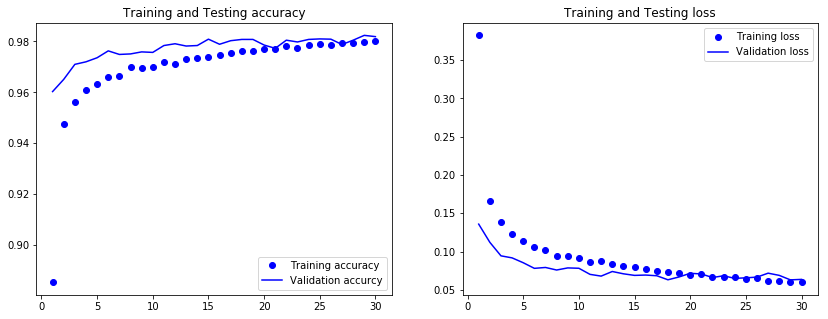

In [27]:
print (history.history.keys())

train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']


fig = plt.figure(figsize = (14, 5))
fig.add_subplot(1, 2, 1)
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b-', label = 'Validation accurcy')
plt.legend()
plt.title('Training and Testing accuracy')

fig.add_subplot(1, 2, 2)
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b-', label = 'Validation loss')
plt.legend()
plt.title('Training and Testing loss')

## VGG16 as feature extractor & feed the features to the top layer repalced VGG

with data augmentation and adapting learning rate 

In [11]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (56, 56, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 56, 56, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)       0         
__________

In [43]:
# load the preprocessed MNIST data (56, 56, 3)

x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

print(y_train.shape)
print(x_train.shape)

(60000, 10)
(60000, 56, 56, 3)


In [12]:
# stack the Dense layer on top of top layer removed VGG16

replaced_model = Sequential()

replaced_model.add(conv_base)
replaced_model.add(Flatten())
replaced_model.add(Dense(256, activation = 'relu'))
replaced_model.add(Dropout(0.5))
replaced_model.add(Dense(10, activation = 'softmax'))

replaced_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 14,848,586
Trainable params: 14,848,586
Non-trainable params: 0
_________________________________________________________________


In [13]:
print ('number of trainable weight matrics before freezing:', len(replaced_model.trainable_weights))

conv_base.trainable = False

print ('number of trainable weight matrics after freezing:', len(replaced_model.trainable_weights))


number of trainable weight matrics before freezing: 30
number of trainable weight matrics after freezing: 4


#### Data augmentation & Adapting learning rate 

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers 

In [15]:
# ImageDataGenerator - Generates batches of tensor image data with real-time data augmentation, augmented data is looped in BATCHS

train_datagen = ImageDataGenerator(# rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

# testing data shouldn't be augmented
test_datagen = ImageDataGenerator()

# Compute the internal data stats related to the data-dependent transformations, based on an array of sample data. 
# Only required if featurewise_center or featurewise_std_normalization or zca_whitening.

# train_datagen.fit(x_train)
# test_datagen.fit(x_test)

In [ ]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

# define Callback functions which will be called by model during runtime when specified conditions are satisfied

# ReduceLROnPlateau - Reduce learning rate when a metric has stopped improving
lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1), #  new_lr = lr * factor
                               cooldown = 0, # number of epochs to wait before resuming normal operation after lr has been reduced.
                               patience = 2, min_lr = 0.5e-6)
csv_logger = CSVLogger('./vgg16imagenetpretrained_mnist0_data_argumentation.csv')
early_stopper = EarlyStopping(min_delta = 0.001, patience = 10)

opt = optimizers.rmsprop(lr = 0.0001, decay = 1e-6)

# model compilation 
replaced_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


# model fitting
batch_size = 32
epochs = 5

# fit_generator - Fits the model on data generated batch-by-batch by a Python generator
# train_datagen.flow - flow method takes numpy data & label arrays and generates batches of augmented/normalized data.
history = replaced_model.fit_generator(train_datagen.flow(x_train, y_train, batch_size = batch_size), 
                             steps_per_epoch = len(x_train)// batch_size, 
                                       epochs = epochs, validation_data = (x_test, y_test),
                                      callbacks = [lr_reducer, early_stopper, csv_logger])

Epoch 1/5
1266/1875 [===================>..........] - ETA: 101s - loss: 2.3015 - acc: 0.1125

In [ ]:
replaced_model.save_weights("mnist_adam_vgg_lr_reducer.h5")

In [ ]:
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:5]:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(16, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


# Train the model 
model_final.fit_generator(
train_generator,
samples_per_epoch = nb_train_samples,
epochs = epochs,
validation_data = validation_generator,
nb_val_samples = nb_validation_samples,
callbacks = [checkpoint, early])

